In [1]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import mean_absolute_error
from pandas import DataFrame
from pandas import Series
from pmdarima.arima import auto_arima
import numpy as np
from sklearn.utils import resample
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_Rows', 13000)
pd.set_option('display.max_columns', 12000)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from termcolor import colored
from math import pi
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from xgboost import XGBRegressor

# 90+DPD  (DAYS PAST DUE)

In [2]:
data_vintage = pd.read_excel('poland_90+_vintage.xlsx')
data_vintage.head()

,CLIENT,CUSTOMER_TYPE_DETAILED,POS_SEGMENT,RISK_SEGMENT,COHORT,MOB,COUNT(*),SUM(ISSUED_GROSS),sum(OUTSTANDING_EOM_prior),DPD90_ACC,DPD90_TOPFP,DPD90_OP
0,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,0,239,587723.65,0.00,0,0.00,0.00
1,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,1,239,587723.65,651806.49,0,0.00,0.00
2,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,2,239,587723.65,573688.39,0,0.00,0.00
3,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,3,239,587723.65,558428.10,0,0.00,0.00
4,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,4,239,587723.65,449126.05,20,55604.18,44861.97


In [3]:
data_vintage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25100 entries, 0 to 25099
Data columns (total 12 columns):
CLIENT                        25100 non-null object
CUSTOMER_TYPE_DETAILED        25100 non-null object
POS_SEGMENT                   9604 non-null object
RISK_SEGMENT                  15496 non-null object
COHORT                        25100 non-null object
MOB                           25100 non-null int64
COUNT(*)                      25100 non-null int64
SUM(ISSUED_GROSS)             25100 non-null float64
sum(OUTSTANDING_EOM_prior)    25100 non-null float64
DPD90_ACC                     25100 non-null int64
DPD90_TOPFP                   25100 non-null float64
DPD90_OP                      25100 non-null float64
dtypes: float64(4), int64(3), object(5)
memory usage: 2.3+ MB


In [4]:
data_vintage['SUM(ISSUED_GROSS)'] = data_vintage['SUM(ISSUED_GROSS)'].apply(np.int64)
data_vintage['sum(OUTSTANDING_EOM_prior)'] = data_vintage['sum(OUTSTANDING_EOM_prior)'].apply(np.int64)
data_vintage['DPD90_ACC'] = data_vintage['DPD90_ACC'].apply(np.int64)
data_vintage['DPD90_TOPFP'] = data_vintage['DPD90_TOPFP'].apply(np.int64)
data_vintage['DPD90_OP'] = data_vintage['DPD90_OP'].apply(np.int64)

In [5]:
data_vintage.head()

,CLIENT,CUSTOMER_TYPE_DETAILED,POS_SEGMENT,RISK_SEGMENT,COHORT,MOB,COUNT(*),SUM(ISSUED_GROSS),sum(OUTSTANDING_EOM_prior),DPD90_ACC,DPD90_TOPFP,DPD90_OP
0,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,0,239,587723,0,0,0,0
1,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,1,239,587723,651806,0,0,0
2,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,2,239,587723,573688,0,0,0
3,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,3,239,587723,558428,0,0,0
4,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,4,239,587723,449126,20,55604,44861


In [6]:
Total_account_byProduct= data_vintage.groupby('CLIENT', as_index=False).agg({"COUNT(*)": "sum"})
#Total_account_byProduct= data_vintage.groupby('CLIENT', as_index=False).agg(Total_account_byProduct=("COUNT(*)", sum))

In [7]:
Total_account_byProduct

,CLIENT,COUNT(*)
0,MONEDONOW_ES,2232151
1,MONEDONOW_PL,2539653
2,MONEDO_FINANCE_PL,7966842


In [8]:
data_base_grouped=data_vintage.groupby('CLIENT', as_index=False).agg({"SUM(ISSUED_GROSS)": "sum"})
data_base_grouped

,CLIENT,SUM(ISSUED_GROSS)
0,MONEDONOW_ES,3599227993
1,MONEDONOW_PL,2156737493
2,MONEDO_FINANCE_PL,3320403887


# MONEDONOW_Poland

In [9]:
#Make Sure data only have one product from poland
#filter_1 = data_vintage["CLIENT"].isin(["MONEDONOW_PL"]) 
#MONEDONOW_pl= data_vintage[filter_1]
MONEDONOW_pl = data_vintage

In [10]:
#func_table=pd.pivot_table(MONEDONOW_pl[MONEDONOW_pl.MOB == 1],values=['COUNT(*)'], index=['COHORT'],aggfunc=np.sum)
#func_table= func_table.reset_index(drop=True)
#total_count_opened = func_table['COUNT(*)'].tolist()
filter_1 = MONEDONOW_pl[MONEDONOW_pl['MOB'] == 1]
func_table = filter_1.groupby(['COHORT'])['COUNT(*)'].sum()
#func_table= func_table.reset_index(drop=True)
#func_list = func_table.tolist()
func_table

COHORT
2016-05     1691
2016-06     2503
2016-07     4327
2016-08     4352
2016-09     4756
2016-10     5755
2016-11     8891
2016-12     6969
2017-01     3537
2017-02     3107
2017-03     7514
2017-04     3268
2017-05     9062
2017-06    16028
2017-07    13174
2017-08    11219
2017-09    11679
2017-10    16952
2017-11    17574
2017-12    21294
2018-01    15129
2018-02    10196
2018-03    10013
2018-04    10028
2018-05     6571
2018-06     7646
2018-07    10911
2018-08    11660
2018-09    11355
2018-10    10959
2018-11     9781
2018-12     9035
2019-01     8015
2019-02     7739
2019-03     6819
2019-04     8723
2019-05     9284
2019-06     6137
2019-07     7950
2019-08     9994
2019-09    10192
2019-10     8934
2019-11     8857
2019-12     5816
2020-01     4882
2020-02     5573
2020-03     7058
2020-04     7097
2020-05     6082
2020-06     4535
2020-07     3811
2020-08     2515
2020-09     1995
Name: COUNT(*), dtype: int64

In [11]:
pl_table = pd.pivot_table(MONEDONOW_pl, values=['DPD90_ACC'], index=['COHORT'],columns=['MOB'],margins=False ,aggfunc=np.sum)
pd.set_option('display.max_columns', 30)
pl_table.fillna(0)

DPD90_ACC                                                             \
MOB            0    1    2      3      4      5      6      7      8      9    
COHORT                                                                         
2015-08       0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2015-09       0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0    0.0    7.0   
2015-10       0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0    5.0    3.0   
2015-11       0.0  0.0  0.0    0.0    0.0    0.0    0.0    7.0    2.0    0.0   
2015-12       0.0  0.0  0.0    0.0    0.0    0.0    8.0    7.0    5.0    6.0   
2016-01       0.0  0.0  0.0    0.0    0.0   18.0   22.0   16.0   15.0   11.0   
2016-02       0.0  0.0  0.0    0.0   22.0   38.0   46.0   30.0   27.0   26.0   
2016-03       0.0  0.0  0.0    9.0  114.0  157.0  192.0  132.0  120.0   97.0   
2016-04       0.0  0.0  0.0    7.0  119.0  171.0  199.0  149.0  144.0  137.0   
2016-05       0.0  0.0  0.0    8.0  135.0  201.0  249.0  183.0  179.0  150.0   
2016-06       0.0  0.0  0.0   17.0  144.0  224.0  268.0  242.0  208.0  179.0   
2016-07       0.0  0.0  0.0   18.0  154.0  272.0  321.0  271.0  215.0  194.0   
2016-08       0.0  0.0  0.0    5.0  209.0  350.0  447.0  334.0  293.0  241.0   
2016-09       0.0  0.0  0.0   16.0  188.0  315.0  426.0  374.0  307.0  279.0   
2016-10       0.0  0.0  0.0   14.0  192.0  345.0  458.0  395.0  321.0  284.0   
2016-11       0.0  0.0  0.0    2.0  193.0  372.0  510.0  452.0  408.0  320.0   
2016-12       0.0  0.0  0.0    5.0  207.0  363.0  475.0  406.0  348.0  281.0   
2017-01       0.0  0.0  0.0    0.0  160.0  318.0  443.0  319.0  279.0  214.0   
2017-02       0.0  0.0  0.0   21.0  212.0  334.0  392.0  327.0  234.0  173.0   
2017-03       0.0  0.0  0.0   14.0  314.0  456.0  540.0  411.0  308.0  246.0   
2017-04       0.0  0.0  0.0   78.0  246.0  402.0  402.0  330.0  242.0  210.0   
2017-05       0.0  0.0  1.0   81.0  330.0  522.0  546.0  473.0  356.0  314.0   
2017-06       0.0  0.0  0.0   81.0  493.0  661.0  794.0  618.0  581.0  408.0   
2017-07       0.0  0.0  1.0  163.0  553.0  845.0  893.0  808.0  537.0  556.0   
2017-08       0.0  0.0  1.0  131.0  472.0  724.0  831.0  534.0  558.0  182.0   
2017-09       0.0  0.0  0.0   85.0  311.0  513.0  497.0  566.0  211.0  300.0   
2017-10       0.0  0.0  0.0  124.0  360.0  549.0  769.0  287.0  446.0  556.0   
2017-11       0.0  0.0  0.0   58.0  343.0  687.0  349.0  563.0  743.0  565.0   
2017-12       0.0  0.0  0.0   58.0  381.0  310.0  540.0  729.0  602.0  527.0   
2018-01       0.0  0.0  0.0   61.0  252.0  512.0  698.0  622.0  531.0  479.0   
2018-02       0.0  0.0  0.0   62.0  263.0  444.0  522.0  452.0  381.0  334.0   
2018-03       0.0  0.0  0.0   80.0  361.0  618.0  745.0  707.0  567.0  517.0   
2018-04       0.0  0.0  0.0  102.0  350.0  604.0  750.0  682.0  633.0  524.0   
2018-05       0.0  0.0  0.0   68.0  234.0  416.0  426.0  422.0  342.0  298.0   
2018-06       0.0  0.0  0.0   59.0  277.0  443.0  592.0  502.0  422.0  308.0   
2018-07       0.0  0.0  0.0   59.0  363.0  661.0  766.0  614.0  430.0  366.0   
2018-08       0.0  0.0  0.0   90.0  434.0  699.0  785.0  649.0  559.0  457.0   
2018-09       0.0  0.0  0.0   99.0  392.0  605.0  676.0  584.0  472.0  397.0   
2018-10       0.0  0.0  0.0  129.0  370.0  657.0  759.0  623.0  481.0  401.0   
2018-11       0.0  0.0  1.0   51.0  243.0  442.0  519.0  436.0  329.0  301.0   
2018-12       0.0  0.0  0.0   42.0  222.0  422.0  506.0  449.0  412.0  381.0   
2019-01       0.0  0.0  0.0   49.0  263.0  438.0  497.0  459.0  431.0  411.0   
2019-02       0.0  0.0  0.0   82.0  271.0  471.0  601.0  573.0  519.0  384.0   
2019-03       0.0  0.0  0.0   46.0  211.0  425.0  531.0  438.0  370.0  297.0   
2019-04       0.0  0.0  0.0   30.0  197.0  365.0  432.0  396.0  343.0  266.0   
2019-05       0.0  0.0  0.0   59.0  225.0  380.0  425.0  382.0  303.0  212.0   
2019-06       0.0  0.0  1.0   72.0  203.0  288.0  266.0  195.0  192.0  153.0   
2019-07 

In [12]:
pl_table_final = pd.pivot_table(MONEDONOW_pl, values=['DPD90_ACC'], index=['COHORT'],columns=['MOB'],margins=False, fill_value=0,aggfunc=np.sum)
pd.set_option('display.max_columns', 30)
pl_table_final=pl_table_final.fillna(0).astype(int)
pl_table_final.columns = pl_table_final.columns.droplevel(0)
#pl_table_final['Total_Account_opened'] = func_list
pl_table_final.head()

MOB,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
COHORT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-08,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-09,0,0,0,0,0,0,0,0,0,7,3,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-10,0,0,0,0,0,0,0,0,5,3,1,1,2,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-11,0,0,0,0,0,0,0,7,2,0,1,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-12,0,0,0,0,0,0,8,7,5,6,4,5,5,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
#pl_table_precent = pl_table_final.div(pl_table_final.Total_Account_opened, axis='index')
#pl_table_precent.head()

In [14]:
#pl_table_precent_final = pl_table_precent.drop('Total_Account_opened',axis=1)
#pl_table_precent_final.head()

(62.5, -0.9)

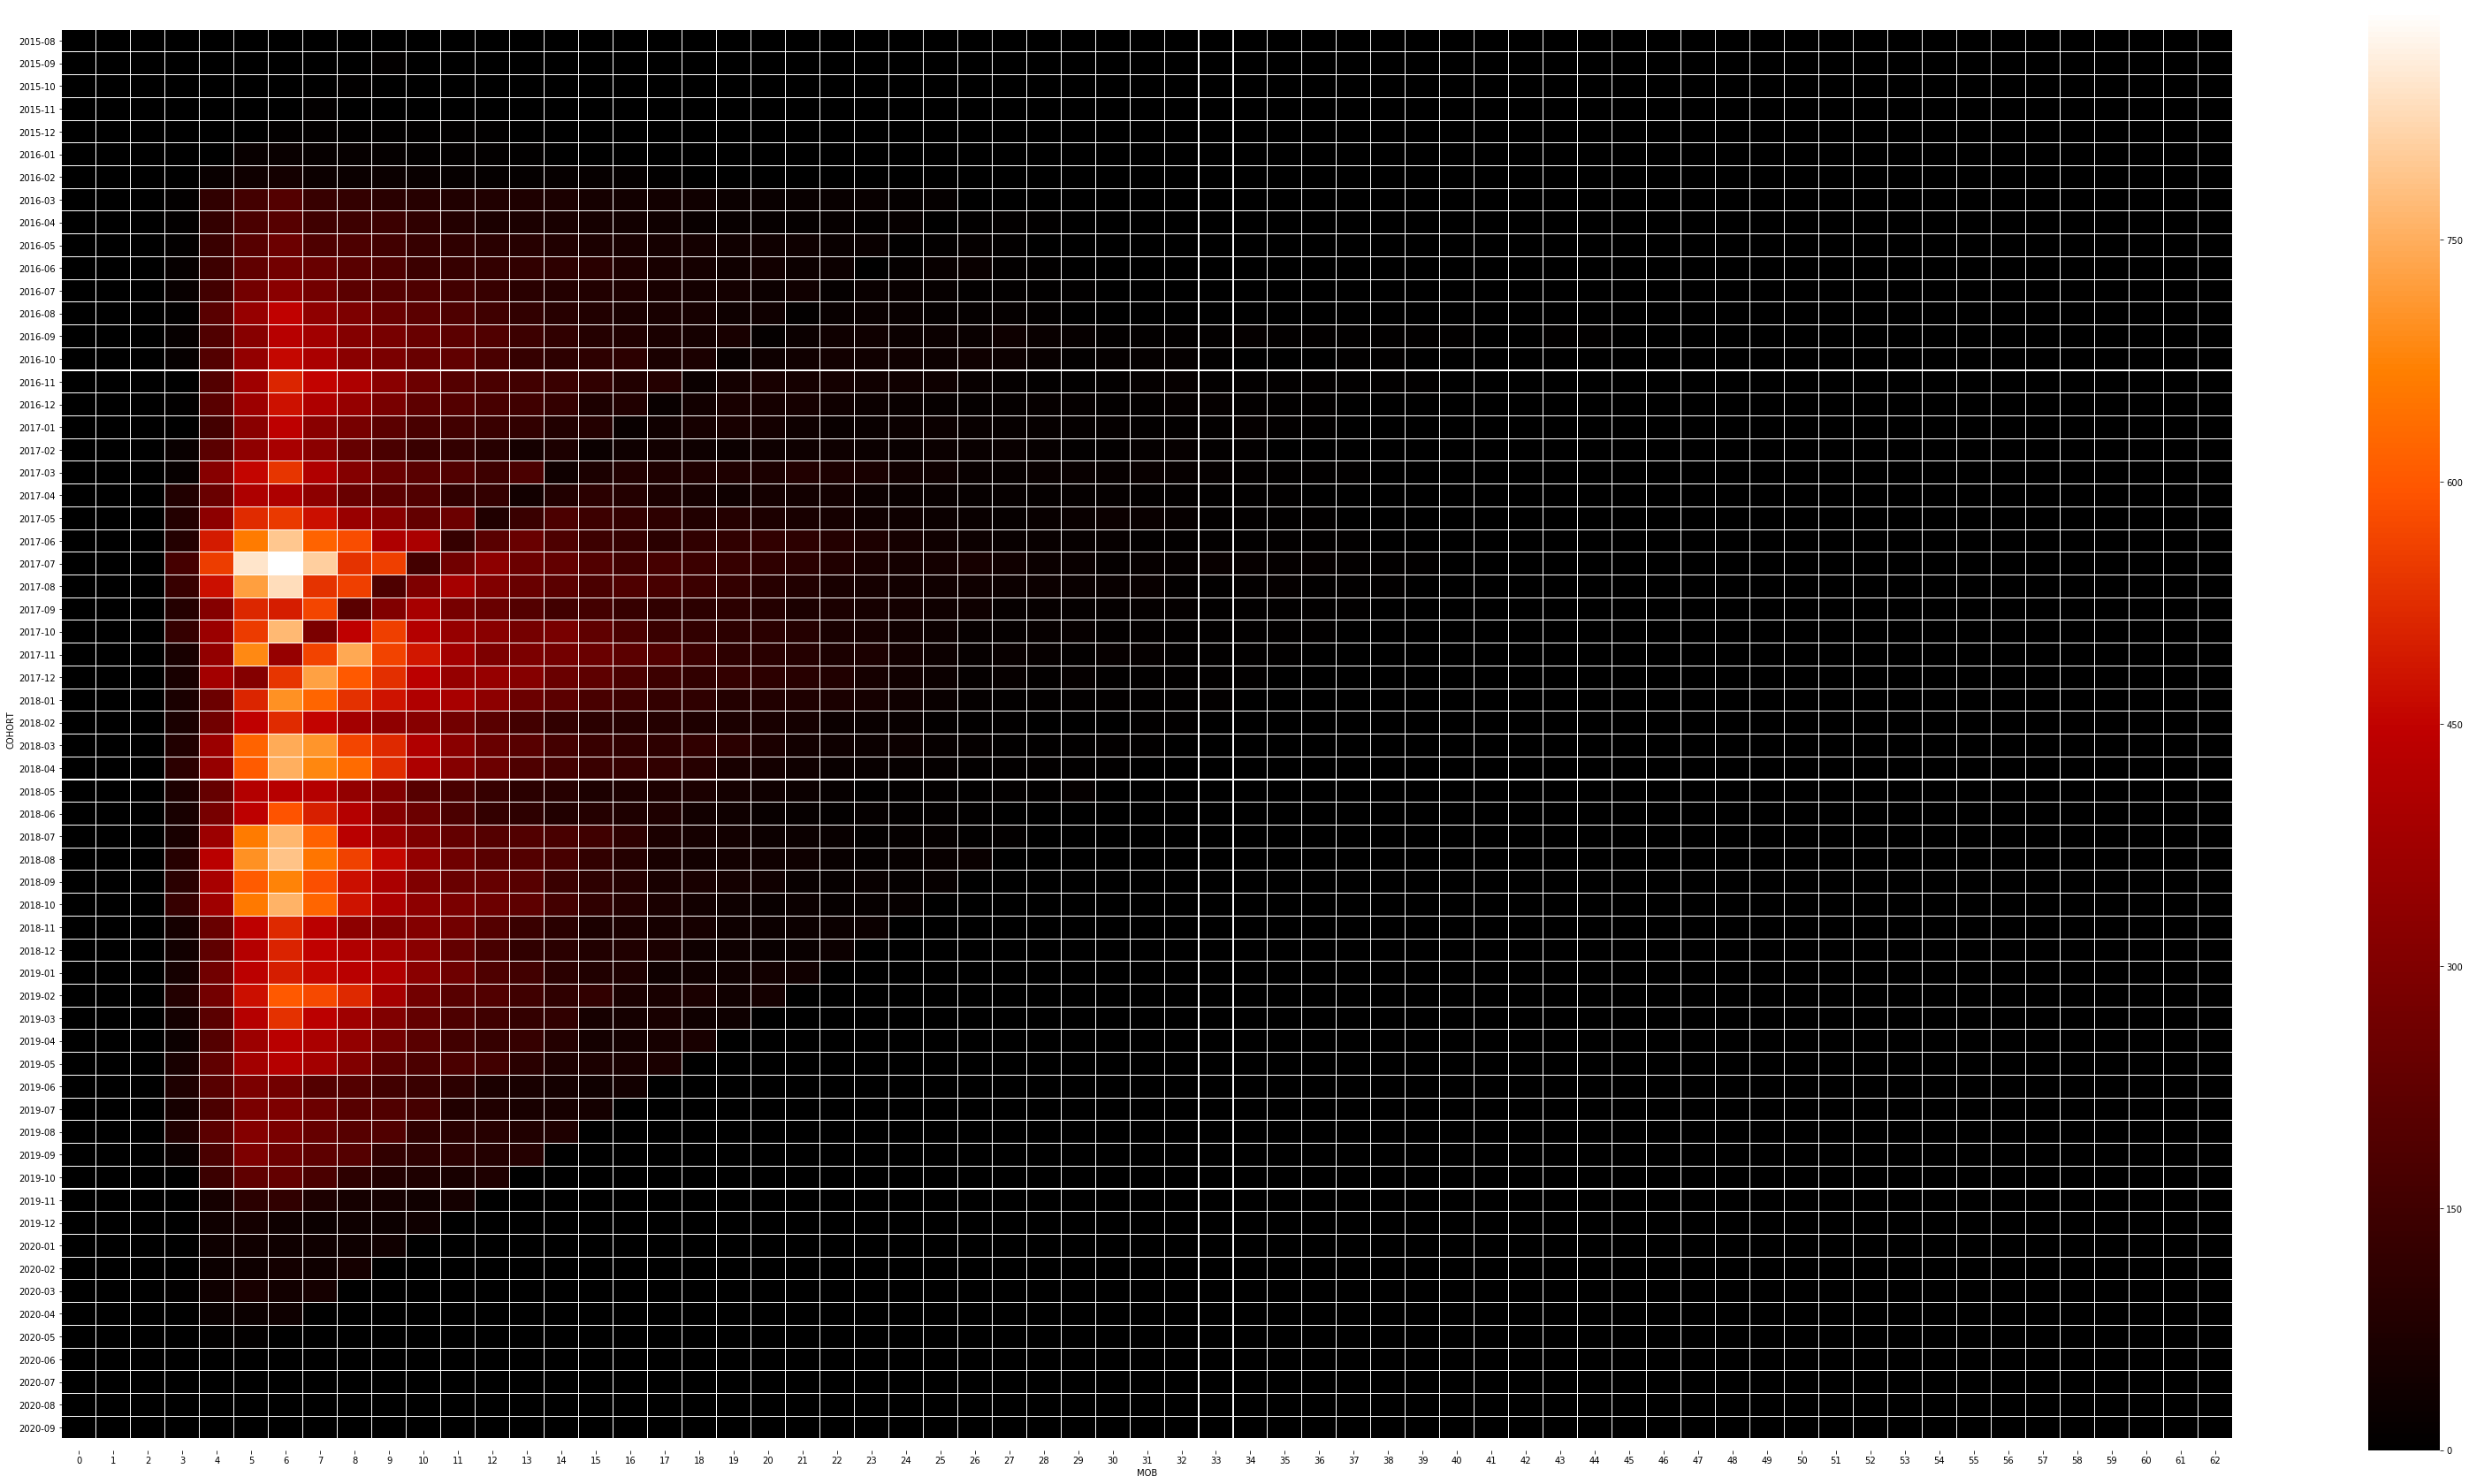

In [15]:
f, ax = plt.subplots(figsize=(55, 30))
sns.heatmap(pl_table_final, annot=False,linewidths=.05, fmt="d",cmap="gist_heat", ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.9)

(62.5, -0.9)

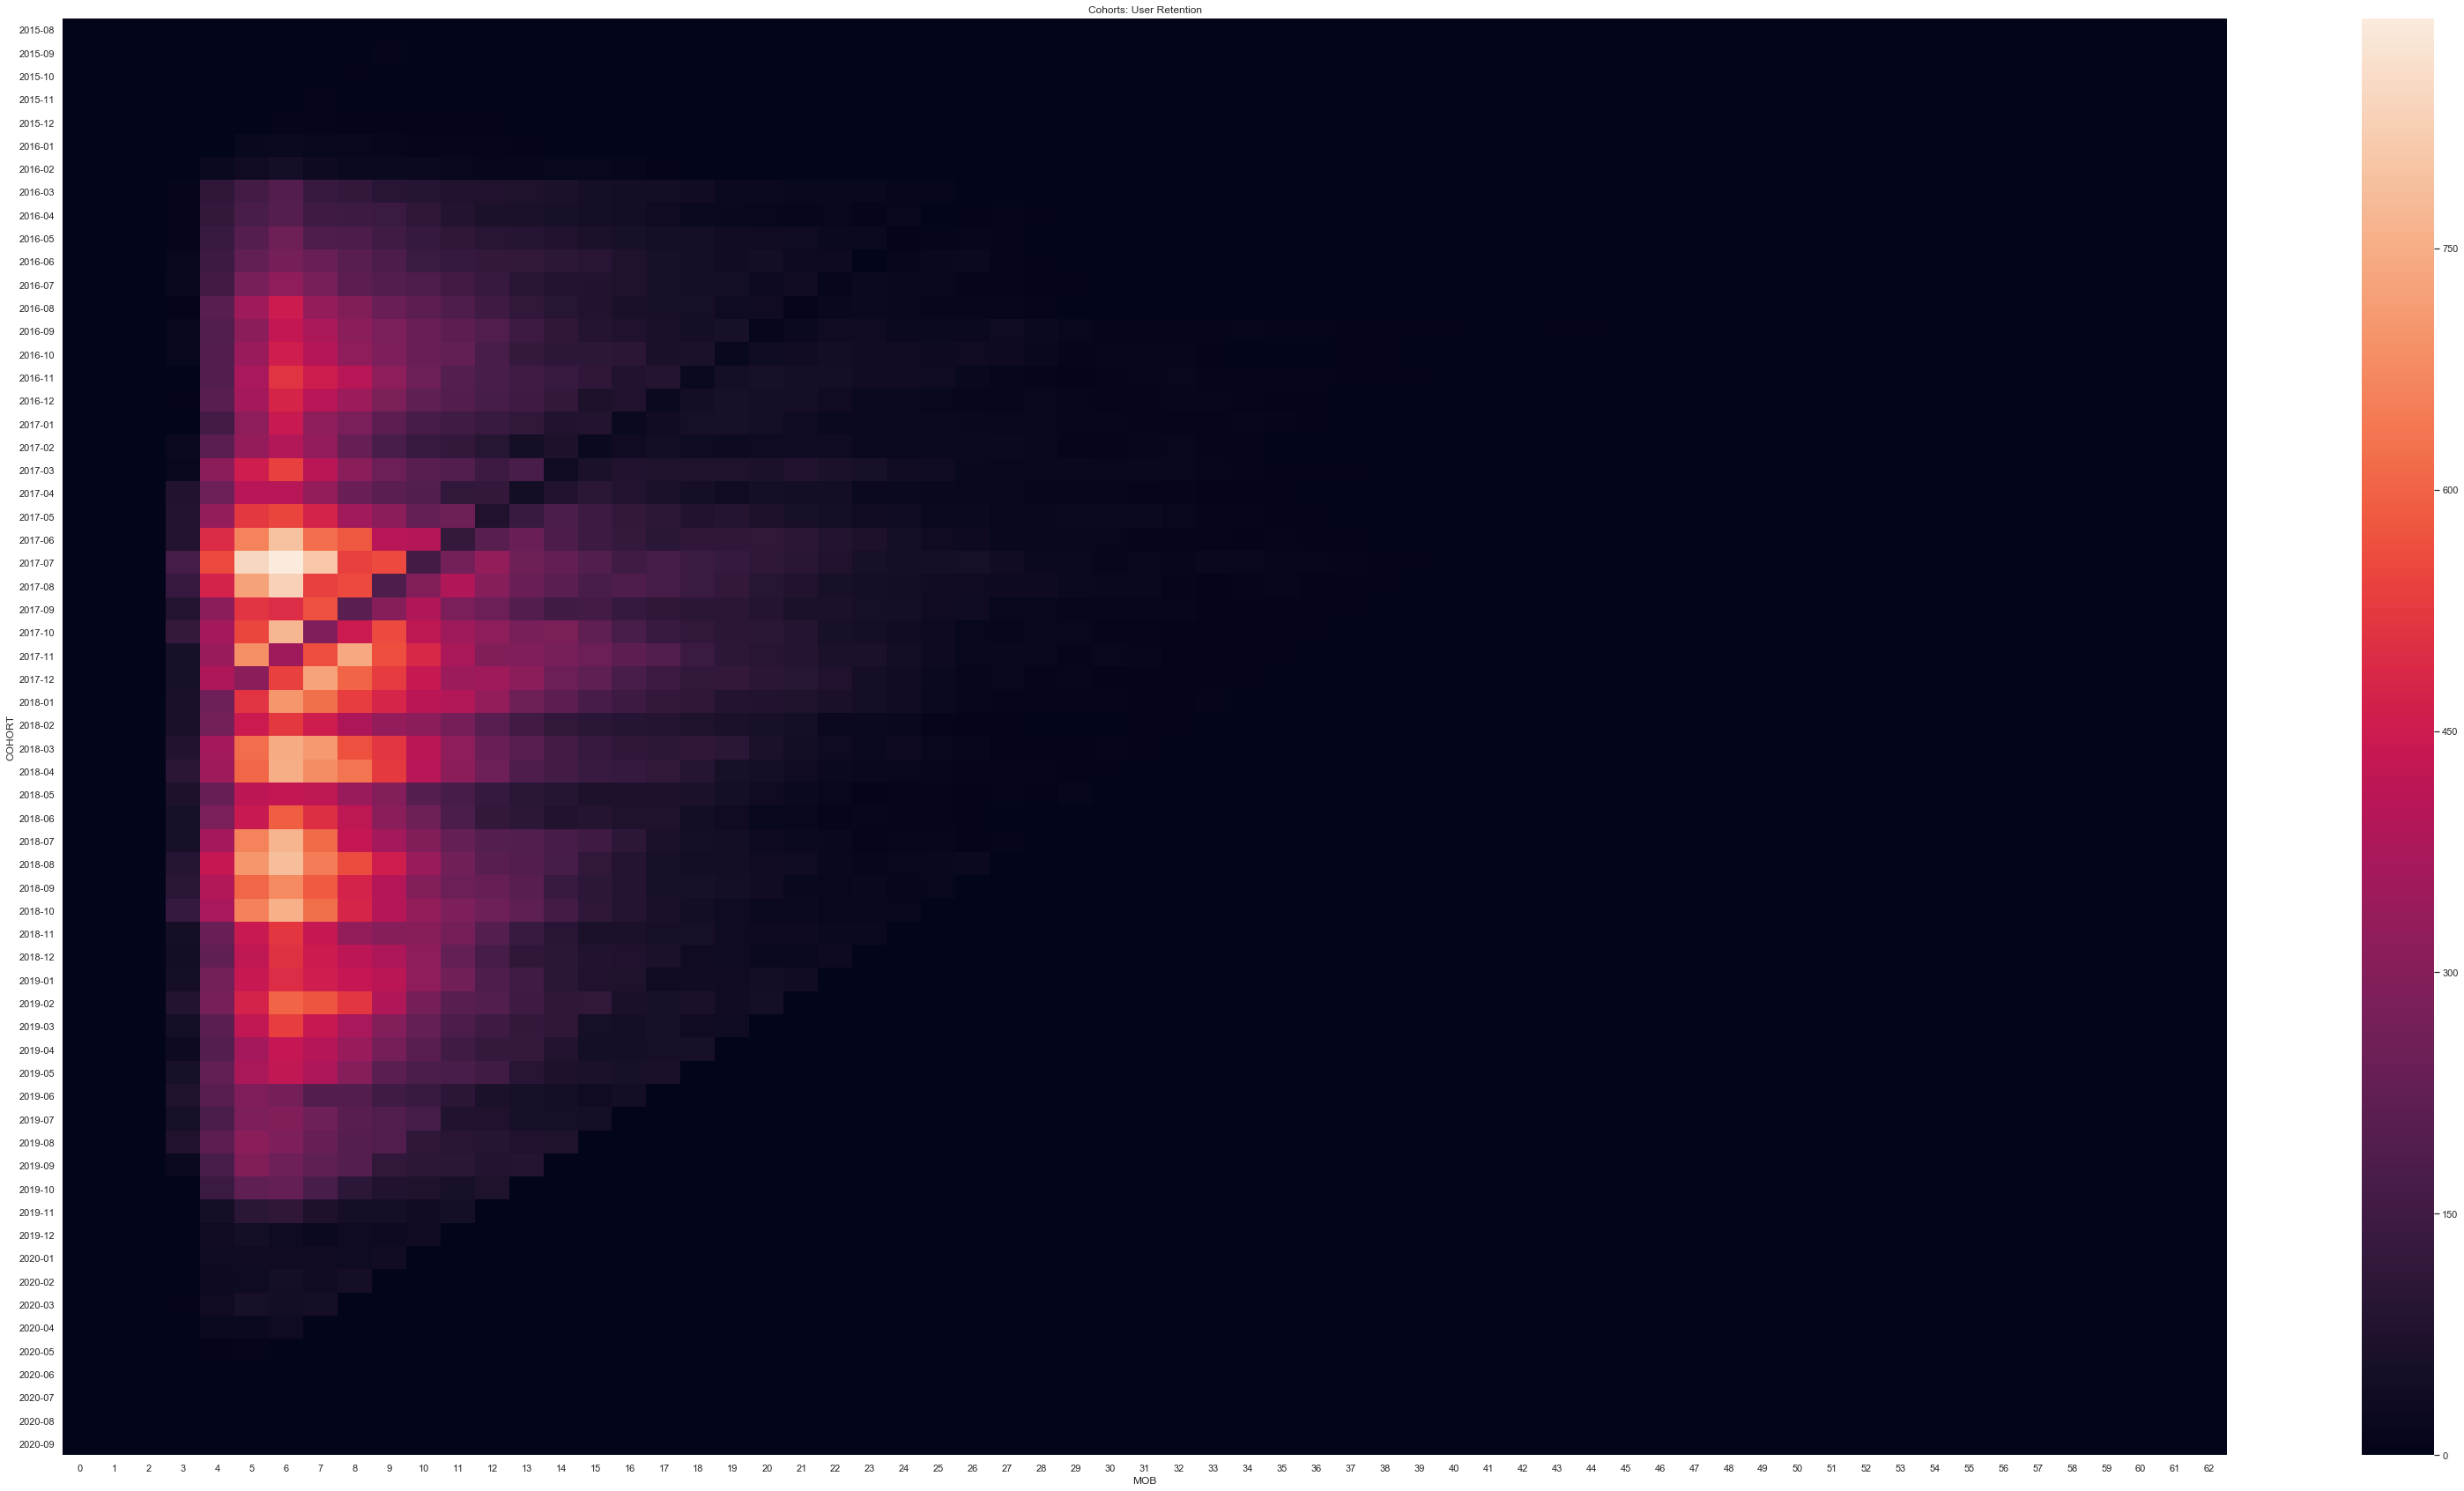

In [16]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(55, 30))
plt.title('Cohorts: User Retention')

sns.heatmap(pl_table_final, mask=pl_table_final.isnull(), annot=False, fmt='%');
ax.set_ylim(bottom + 0.5, top - 0.9)

In [17]:
dpd_90_MOB = pl_table_final[6]

# DPD30+

In [18]:
data_vintage_30dpd = pd.read_excel('dpd30+_vintage.xlsx')
data_vintage_30dpd.head()

,CLIENT,CUSTOMER_TYPE_DETAILED,POS_SEGMENT,RISK_SEGMENT,COHORT,MOB,COUNT(*),SUM(ISSUED_GROSS),sum(OUTSTANDING_EOM_prior),DPD30_ACC,DPD30_TOPFP,DPD30_OP
0,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,0,239,587723.65,0.00,0,0.00,0.00
1,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,1,239,587723.65,651806.49,0,0.00,0.00
2,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,2,239,587723.65,573688.39,22,54382.61,47685.97
3,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,3,239,587723.65,558428.10,28,79009.38,65290.87
4,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,4,239,587723.65,449126.05,43,118344.10,100544.66


In [19]:
data_vintage_30dpd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25100 entries, 0 to 25099
Data columns (total 12 columns):
CLIENT                        25100 non-null object
CUSTOMER_TYPE_DETAILED        25100 non-null object
POS_SEGMENT                   9604 non-null object
RISK_SEGMENT                  15496 non-null object
COHORT                        25100 non-null object
MOB                           25100 non-null int64
COUNT(*)                      25100 non-null int64
SUM(ISSUED_GROSS)             25100 non-null float64
sum(OUTSTANDING_EOM_prior)    25100 non-null float64
DPD30_ACC                     25100 non-null int64
DPD30_TOPFP                   25100 non-null float64
DPD30_OP                      25100 non-null float64
dtypes: float64(4), int64(3), object(5)
memory usage: 2.3+ MB


In [20]:
data_vintage_30dpd['SUM(ISSUED_GROSS)'] = data_vintage_30dpd['SUM(ISSUED_GROSS)'].apply(np.int64)
data_vintage_30dpd['sum(OUTSTANDING_EOM_prior)'] = data_vintage_30dpd['sum(OUTSTANDING_EOM_prior)'].apply(np.int64)
data_vintage_30dpd['DPD30_ACC'] = data_vintage_30dpd['DPD30_ACC'].apply(np.int64)
data_vintage_30dpd['DPD30_TOPFP'] = data_vintage_30dpd['DPD30_TOPFP'].apply(np.int64)
data_vintage_30dpd['DPD30_OP'] = data_vintage_30dpd['DPD30_OP'].apply(np.int64)

In [21]:
data_vintage_30dpd.head()

,CLIENT,CUSTOMER_TYPE_DETAILED,POS_SEGMENT,RISK_SEGMENT,COHORT,MOB,COUNT(*),SUM(ISSUED_GROSS),sum(OUTSTANDING_EOM_prior),DPD30_ACC,DPD30_TOPFP,DPD30_OP
0,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,0,239,587723,0,0,0,0
1,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,1,239,587723,651806,0,0,0
2,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,2,239,587723,573688,22,54382,47685
3,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,3,239,587723,558428,28,79009,65290
4,MONEDONOW_ES,CONSOLIDATON_PRODUCT_REPEAT,NaN,CHECK,2017-03,4,239,587723,449126,43,118344,100544


In [22]:
#Make Sure data only have one product from poland
#filter_2 = data_vintage_30dpd["CLIENT"].isin(["MONEDONOW_PL"]) 
#MONEDONOW_pl_30dpd= data_vintage_30dpd[filter_2]
MONEDONOW_pl_30dpd = data_vintage_30dpd

In [23]:
filter_2 = MONEDONOW_pl_30dpd[MONEDONOW_pl_30dpd['MOB'] == 1]
func_table_30dpd = filter_2.groupby(['COHORT'])['COUNT(*)'].sum()
func_table_30dpd = func_table_30dpd.reset_index(drop=True)
func_table_30dpd = func_table_30dpd.tolist()
func_table_30dpd

[1691,
 2503,
 4327,
 4352,
 4756,
 5755,
 8891,
 6969,
 3537,
 3107,
 7514,
 3268,
 9062,
 16028,
 13174,
 11219,
 11679,
 16952,
 17574,
 21294,
 15129,
 10196,
 10013,
 10028,
 6571,
 7646,
 10911,
 11660,
 11355,
 10959,
 9781,
 9035,
 8015,
 7739,
 6819,
 8723,
 9284,
 6137,
 7950,
 9994,
 10192,
 8934,
 8857,
 5816,
 4882,
 5573,
 7058,
 7097,
 6082,
 4535,
 3811,
 2515,
 1995]

In [24]:
pl_table_30dpd = pd.pivot_table(MONEDONOW_pl_30dpd, values=['DPD30_ACC'], index=['COHORT'],columns=['MOB'],margins=False ,aggfunc=np.sum)
pd.set_option('display.max_columns', 30)
pl_table_30dpd.fillna(0)

DPD30_ACC                                                       \
MOB            0      1      2      3       4       5       6       7    
COHORT                                                                   
2015-08       0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2015-09       0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2015-10       0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0   
2015-11       0.0    0.0    0.0    0.0     0.0     0.0     0.0     7.0   
2015-12       0.0    0.0    0.0    0.0     0.0     0.0    14.0    12.0   
2016-01       0.0    0.0    0.0    0.0     0.0    30.0    31.0    22.0   
2016-02       0.0    0.0    0.0    0.0    48.0    56.0    68.0    55.0   
2016-03       0.0    0.0    0.0  177.0   226.0   269.0   291.0   214.0   
2016-04       0.0    0.0  127.0  190.0   240.0   289.0   326.0   251.0   
2016-05       0.0    3.0  148.0  222.0   300.0   359.0   387.0   303.0   
2016-06       0.0   10.0  166.0  254.0   342.0   413.0   421.0   384.0   
2016-07       0.0   17.0  166.0  307.0   404.0   464.0   498.0   437.0   
2016-08       0.0    2.0  244.0  395.0   516.0   611.0   658.0   532.0   
2016-09       0.0   13.0  199.0  383.0   518.0   615.0   681.0   590.0   
2016-10       0.0    4.0  246.0  417.0   524.0   642.0   714.0   624.0   
2016-11       0.0    5.0  237.0  422.0   590.0   721.0   853.0   720.0   
2016-12       0.0   20.0  223.0  401.0   521.0   693.0   734.0   629.0   
2017-01       0.0    0.0  188.0  323.0   485.0   549.0   662.0   494.0   
2017-02       0.0   16.0  202.0  361.0   435.0   570.0   560.0   450.0   
2017-03       0.0    4.0  431.0  486.0   684.0   750.0   777.0   617.0   
2017-04       0.0   63.0  209.0  440.0   529.0   620.0   597.0   482.0   
2017-05       1.0   37.0  346.0  497.0   672.0   816.0   786.0   697.0   
2017-06       0.0   57.0  407.0  659.0   962.0  1067.0  1186.0  1032.0   
2017-07       1.0   93.0  554.0  925.0  1119.0  1377.0  1444.0  1319.0   
2017-08       0.0   83.0  520.0  772.0  1048.0  1248.0  1321.0  1033.0   
2017-09       0.0   84.0  340.0  622.0   861.0  1019.0   999.0   958.0   
2017-10       0.0   83.0  490.0  828.0  1075.0  1269.0  1369.0   719.0   
2017-11       0.0  133.0  468.0  766.0  1196.0  1388.0   907.0  1005.0   
2017-12       0.0  103.0  425.0  827.0  1134.0   934.0  1028.0  1131.0   
2018-01       0.0   48.0  391.0  768.0   838.0   972.0  1111.0  1011.0   
2018-02       0.0   66.0  275.0  546.0   648.0   770.0   845.0   736.0   
2018-03       0.0   75.0  394.0  642.0   883.0  1143.0  1213.0  1080.0   
2018-04       0.0  116.0  394.0  637.0   928.0  1172.0  1222.0  1068.0   
2018-05       0.0   45.0  247.0  474.0   581.0   706.0   692.0   641.0   
2018-06       0.0   43.0  305.0  497.0   710.0   825.0   885.0   746.0   
2018-07       0.0   58.0  409.0  721.0   895.0  1062.0  1109.0   910.0   
2018-08       0.0   89.0  472.0  751.0   993.0  1194.0  1212.0  1033.0   
2018-09       0.0  104.0  407.0  716.0   901.0  1021.0  1100.0   922.0   
2018-10       1.0  102.0  464.0  772.0   924.0  1139.0  1176.0   958.0   
2018-11       1.0   89.0  322.0  496.0   665.0   780.0   818.0   707.0   
2018-12       0.0   64.0  253.0  488.0   634.0   774.0   807.0   747.0   
2019-01       0.0   54.0  304.0  494.0   654.0   786.0   827.0   785.0   
2019-02       0.0   91.0  329.0  559.0   708.0   876.0   991.0   886.0   
2019-03       0.0   53.0  266.0  392.0   572.0   759.0   796.0   728.0   
2019-04       0.0   39.0  189.0  333.0   492.0   655.0   723.0   610.0   
2019-05       0.0   39.0  200.0  348.0   506.0   691.0   667.0   534.0   
2019-06       0.0   42.0  145.0  274.0   412.0   464.0   387.0   353.0   
2019-07       0.0   21.0  152.0  310.0   411.0   424.0   494.0   437.0   
2019-08       2.0   48.0  256.0  373.0   405.0   539.0   535.0   478.0   
2019-09       0.0   37.0  190.0  255.0   452.0   553.0   503.0   470.0   
2019-10       0.0    8.0   97.0  224.0   361.0   408.0   454.0   366.0   
2019-11     

In [25]:
pl_table_30dpd = pd.pivot_table(MONEDONOW_pl_30dpd, values=['DPD30_ACC'], index=['COHORT'],columns=['MOB'],margins=False ,aggfunc=np.sum)
pd.set_option('display.max_columns', 30)
pl_table_final_30pdp = pl_table_30dpd.fillna(0).astype(int)
pl_table_final_30pdp.columns = pl_table_final_30pdp.columns.droplevel(0)
#pl_table_final_30pdp['Total_Account_opened_30dpd'] = func_table_30dpd
pl_table_final_30pdp.tail()

MOB,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
COHORT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05,0,1,24,37,56,59,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-06,0,0,18,33,35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-07,0,0,5,10,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-08,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(62.5, -0.9)

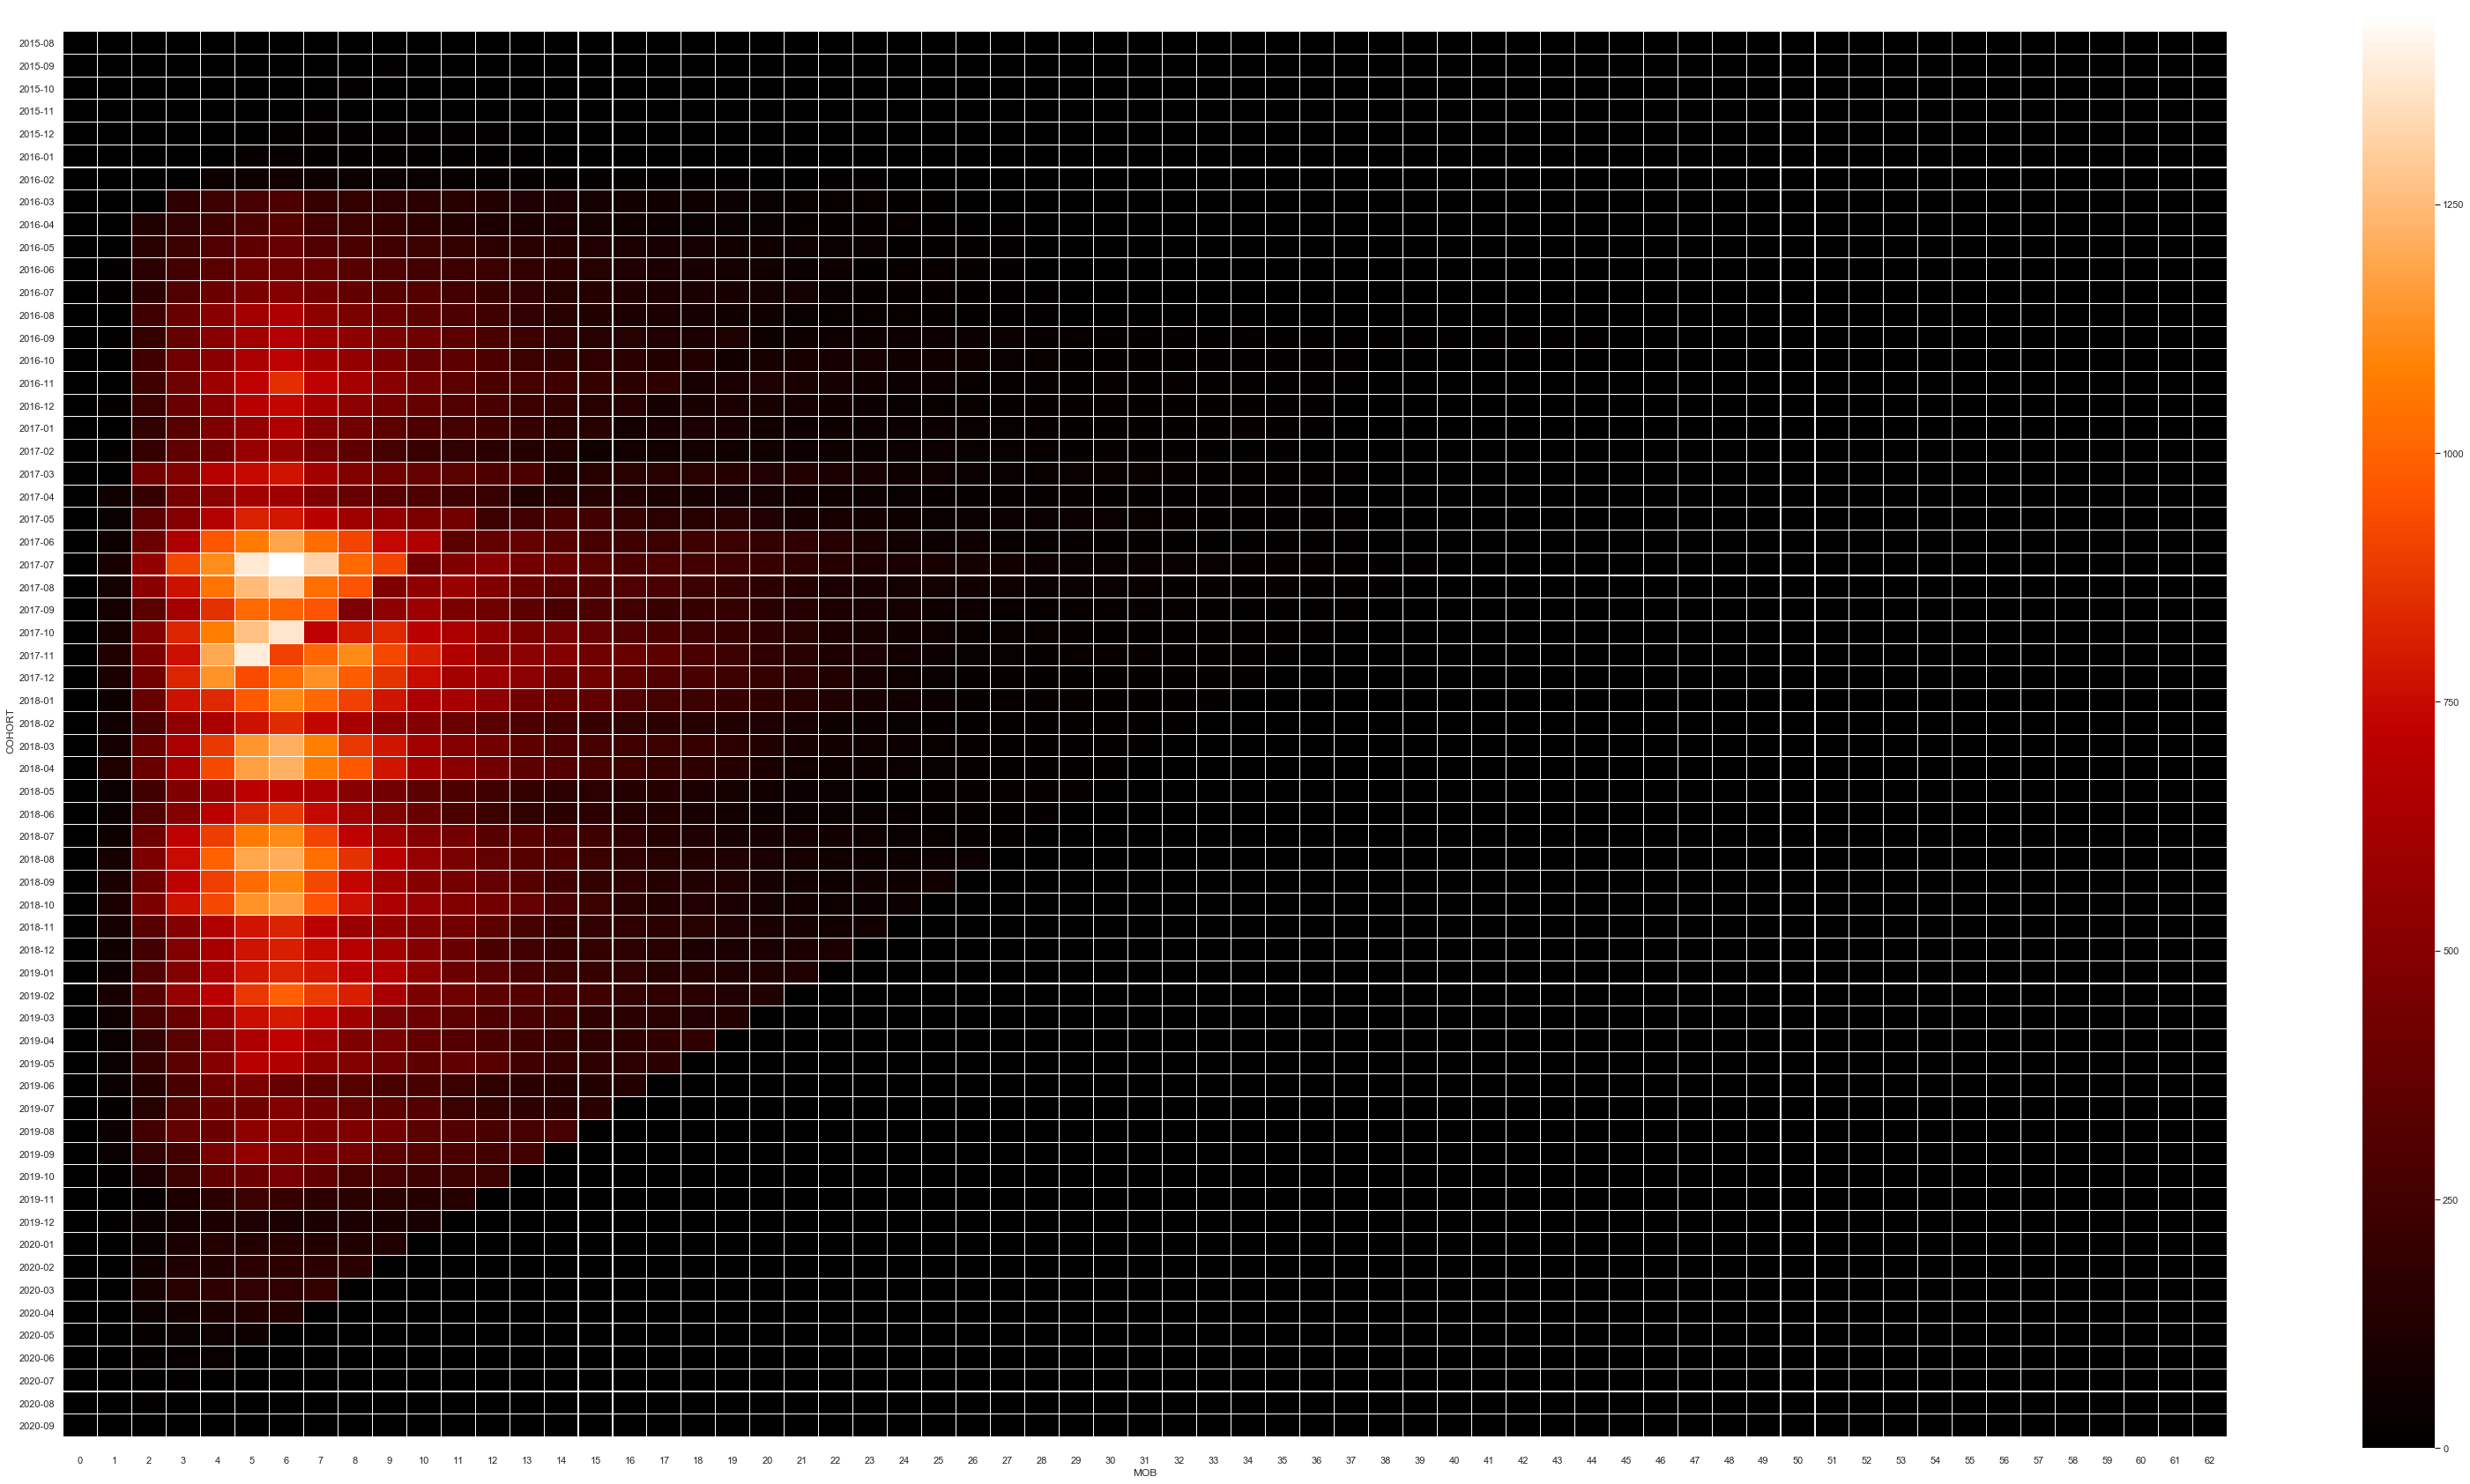

In [26]:
f, ax = plt.subplots(figsize=(55, 30))
sns.heatmap(pl_table_final_30pdp, annot=False,linewidths=.05, fmt="d",cmap="gist_heat", ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.9)

(62.5, -0.9)

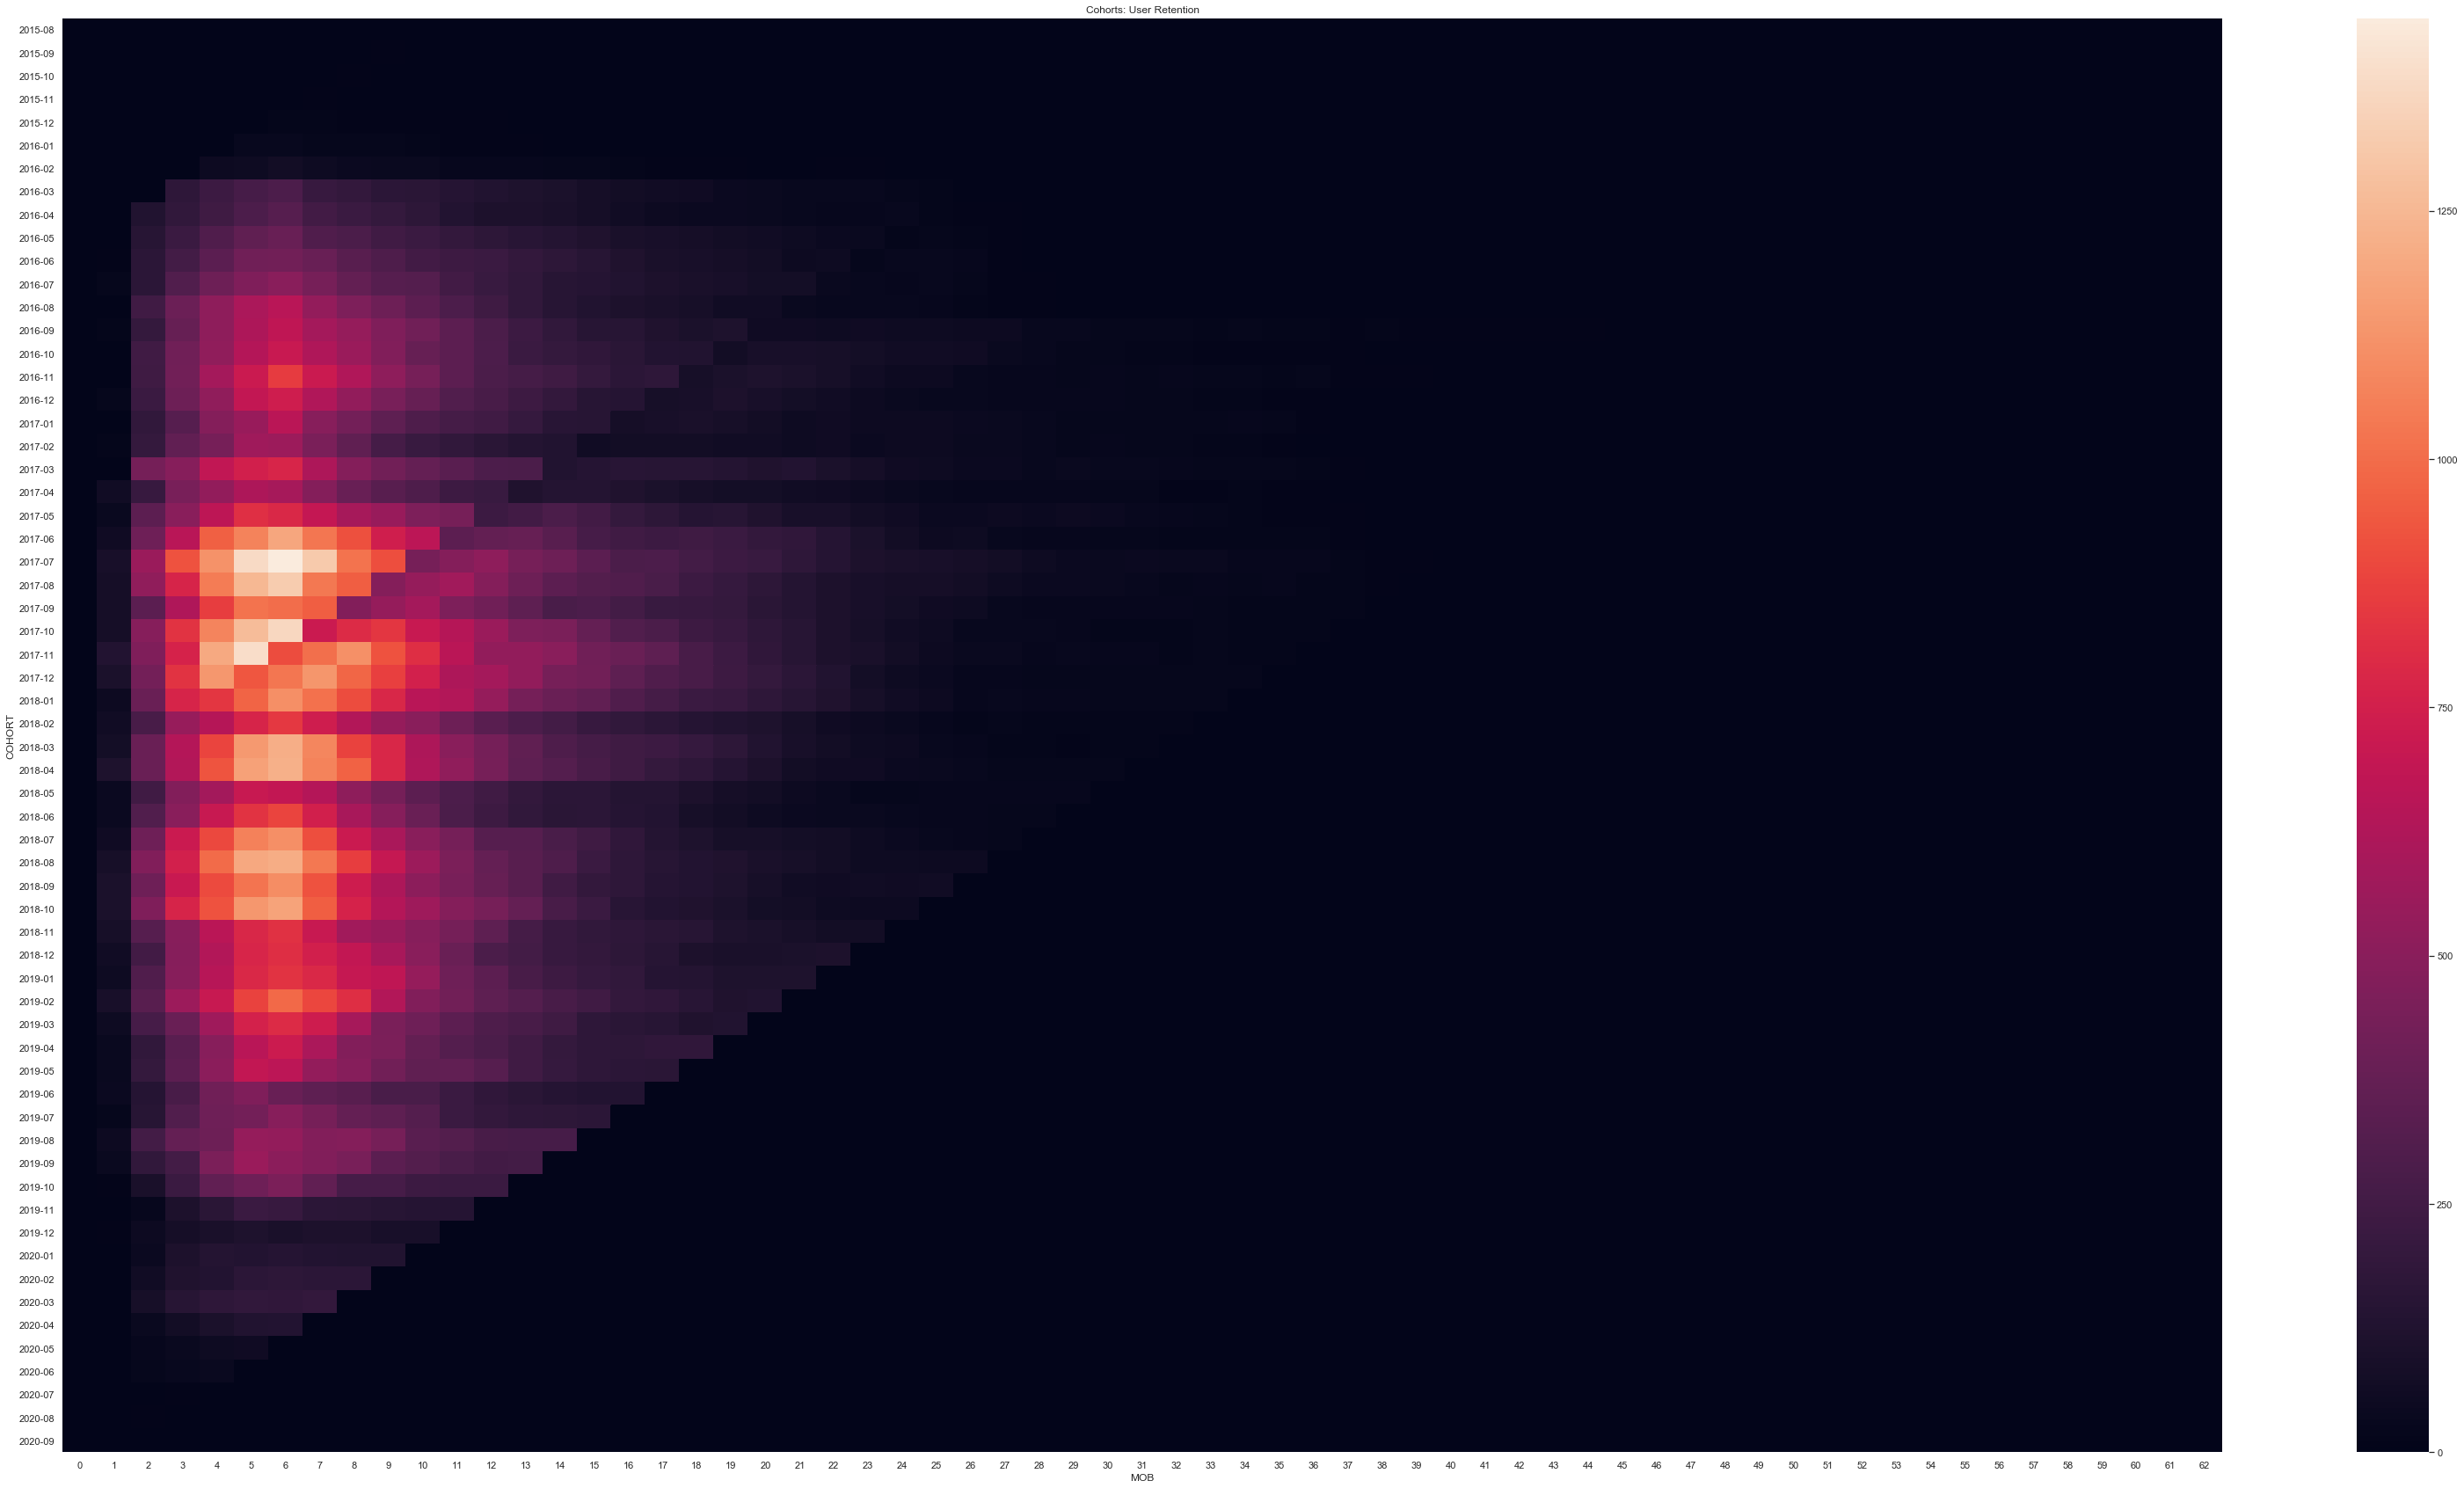

In [27]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(55, 30))
plt.title('Cohorts: User Retention')

sns.heatmap(pl_table_final_30pdp, mask=pl_table_final_30pdp.isnull(), annot=False, fmt='%');
ax.set_ylim(bottom + 0.5, top - 0.9)

# FIND CORRELATION BETWEEN 90+DPD AND 30+ DPD

In [28]:
## For 90+dpd we will use the MOB 5 as dpd start to accumlate while for 30+DPD we have accumlated 2 months earlier so we will use MOB 3

#dpd_90_MOB = pl_table_precent_final[4].tolist()
#dpd_30_MOB = pl_table_precent_final_30dpd[3].tolist()
dpd_90_MOB = pl_table_final[6].tolist()
dpd_30_MOB = pl_table_final_30pdp[3].tolist()
corrl_output= np.corrcoef(dpd_90_MOB, dpd_30_MOB)[0, 1]
print("Pearson correlation coefficients: ")
print(corrl_output)

Pearson correlation coefficients: 
0.9480582905850317


# ARIMA FOR PREDICTION 30+DPD AND 90+ DPD IN THE FUTURE

In [29]:
# Change date to list so i can use in data frame
m = pl_table_final[4].reset_index()
date = m["COHORT"].tolist()

In [30]:
#Building data frame from all target attributes
df_30_90_dpd = pd.DataFrame(list(zip(date,dpd_90_MOB, dpd_30_MOB)), columns =['Date','90_dpd_MOB_6', 'dpd30_MOB_3']) 
#dpd_data = df_30_90_dpd["dpd30_MOB_3"]
df_30_90_dpd = df_30_90_dpd.set_index(df_30_90_dpd.Date)#, drop=True, append=False, inplace=False, verify_integrity=False)
df_30_90_dpd = df_30_90_dpd.drop(['Date'], axis=1)


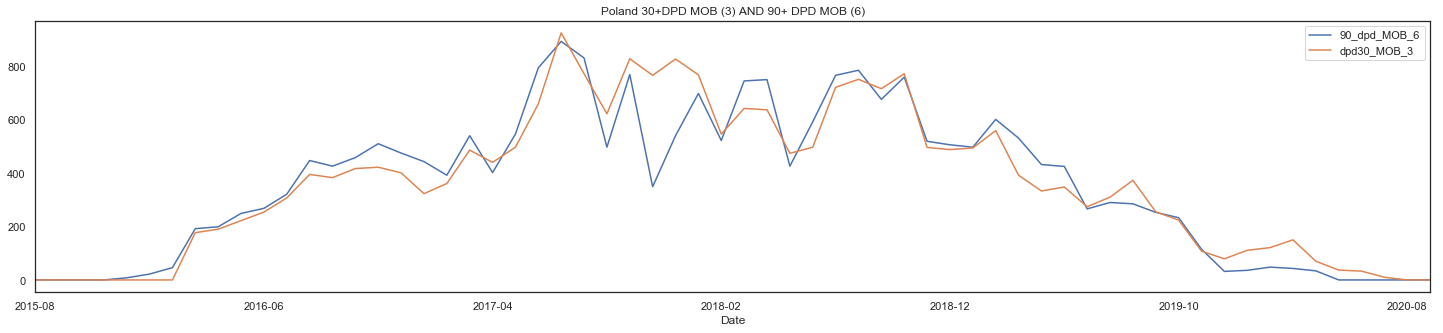

In [31]:
df_30_90_dpd.plot(figsize = (25,5), label = "90+ DPD MOB ")
plt.title('Poland 30+DPD MOB (3) AND 90+ DPD MOB (6)')
plt.legend(loc = 'best')
plt.show()

## Data split

def train_test_split(data):
    data = data.values
    n = int(len(data)- (len(data)*0.1))
    #print(n)
    return data[:n], data[n:]

In [32]:
size= int(len(df_30_90_dpd)*0.80) 
df_30_dpd_train = df_30_90_dpd.iloc[7:size]
df_30_dpd_train.head()

,90_dpd_MOB_6,dpd30_MOB_3
Date,,
2016-03,192,177
2016-04,199,190
2016-05,249,222
2016-06,268,254
2016-07,321,307


In [33]:
print(df_30_dpd_train["dpd30_MOB_3"].describe())

count     42.000000
mean     506.309524
std      195.776813
min      177.000000
25%      364.000000
50%      487.000000
75%      654.750000
max      925.000000
Name: dpd30_MOB_3, dtype: float64


In [34]:
Test_set = df_30_90_dpd.iloc[size:-5] 
Test_set

,90_dpd_MOB_6,dpd30_MOB_3
Date,,
2019-09,253,255
2019-10,233,224
2019-11,115,108
2019-12,32,79
2020-01,36,111
2020-02,48,121
2020-03,43,150
2020-04,34,70


In [35]:
print(Test_set["dpd30_MOB_3"].describe())

count      8.000000
mean     139.750000
std       66.791253
min       70.000000
25%      100.750000
50%      116.000000
75%      168.500000
max      255.000000
Name: dpd30_MOB_3, dtype: float64


In [36]:
print(df_30_90_dpd["dpd30_MOB_3"].describe())

count     62.000000
mean     362.306452
std      268.257253
min        0.000000
25%      113.500000
50%      367.000000
75%      533.750000
max      925.000000
Name: dpd30_MOB_3, dtype: float64


In [37]:
Test_set.dpd30_MOB_3[0]

255

# DPD 30+ PREDICTION

## white noise test: 

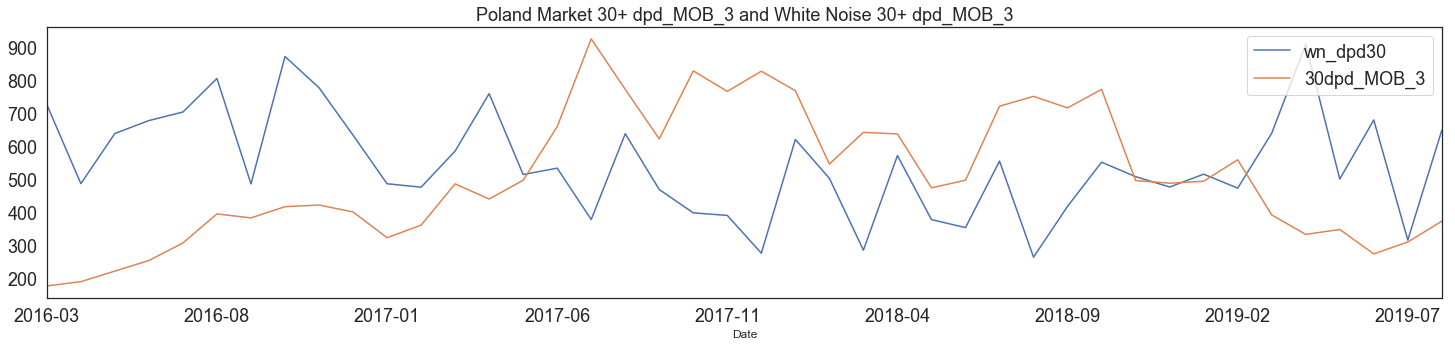

In [38]:
wn_dpd30 = np.random.normal(loc = df_30_dpd_train['dpd30_MOB_3'].mean(), scale =  df_30_dpd_train['dpd30_MOB_3'].std(), size = len(df_30_dpd_train))
df_30_dpd_train['wn_dpd30'] = wn_dpd30
df_30_dpd_train['wn_dpd30'].plot(figsize = (25,5), label = "wn_dpd30",fontsize = 18)
df_30_dpd_train['dpd30_MOB_3'].plot(figsize = (25,5), label = "30dpd_MOB_3",fontsize = 18)
plt.title('Poland Market 30+ dpd_MOB_3 and White Noise 30+ dpd_MOB_3',fontsize = 18)

plt.legend(loc = 'best',fontsize = 18)
plt.show()

## adfuller_test

In [39]:
def adfuller_test(x):
  return sts.adfuller(x)

print ("30dpd_MOB_3 : MOB 3")
print('ADF Statistic: %f' %  adfuller_test(df_30_dpd_train['dpd30_MOB_3'])[0])
print('p-value: %f' % adfuller_test(df_30_dpd_train['dpd30_MOB_3'])[1])
print('Critical Values:')
for key, value in adfuller_test(df_30_dpd_train['dpd30_MOB_3'])[4].items():
    print('\t%s: %.3f' % (key, value))

30dpd_MOB_3 : MOB 3
ADF Statistic: -2.234848
p-value: 0.193841
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606


## Seasonality check

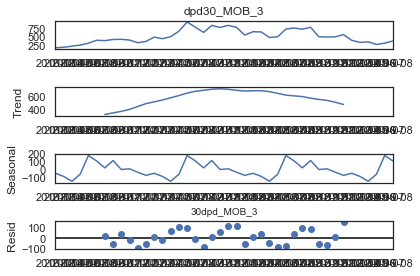

None


In [40]:
def seasonality(f):
    poland_seasonality_additive = seasonal_decompose(f, model = "additative", freq = 12) 
    poland_seasonality_additive.plot()
    plt.title("30dpd_MOB_3", loc='center', size = 10)
    plt.show()

print(seasonality(df_30_dpd_train['dpd30_MOB_3']))

## Treat Seasonality

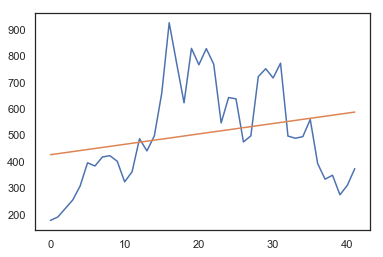

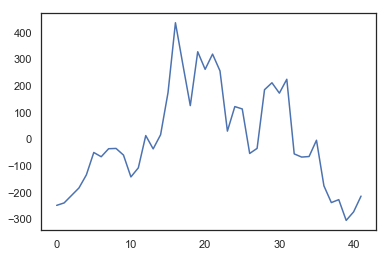

In [41]:
series = (df_30_dpd_train['dpd30_MOB_3'])
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()
# detrend
detrended_dpd = [y[i]-trend[i] for i in range(0, len(series))]
# plot detrended
plt.plot(detrended_dpd)
plt.show()

In [42]:
adfuller_test(detrended_dpd)

(-2.008396560364109,
 0.28290367912630454,
 0,
 41,
 {'1%': -3.60098336718852,
  '5%': -2.9351348158036012,
  '10%': -2.6059629803688282},
 388.1964490319609)

## TREAT STATIONARITY 

In [43]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i]- dataset[i-1]
        diff.append(value)
    return Series(diff)

In [44]:
Stationary_30dpd_MOB_3 = difference(df_30_dpd_train['dpd30_MOB_3'])
adfuller_test(Stationary_30dpd_MOB_3)

(-5.852566379123978,
 3.5609729270570337e-07,
 1,
 39,
 {'1%': -3.610399601308181,
  '5%': -2.939108945868946,
  '10%': -2.6080629651545038},
 378.4586502088608)

In [45]:
print ("30dpd_MOB_3 : MOB 3")
print('ADF Statistic: %f' %  adfuller_test(Stationary_30dpd_MOB_3)[0])
print('p-value: %f' % adfuller_test(Stationary_30dpd_MOB_3)[1])
print('Critical Values:')
for key, value in adfuller_test(Stationary_30dpd_MOB_3)[4].items():
    print('\t%s: %.3f' % (key, value))

30dpd_MOB_3 : MOB 3
ADF Statistic: -5.852566
p-value: 0.000000
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


## ACF TEST 

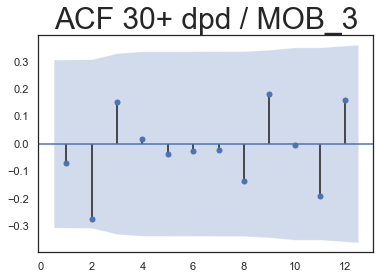

None


In [46]:
def ACF(y):
    sgt.plot_acf(y, zero = False, lags= 12)
    plt.title("ACF 30+ dpd / MOB_3", size  = 30)
    plt.show()
    
print(ACF(Stationary_30dpd_MOB_3))

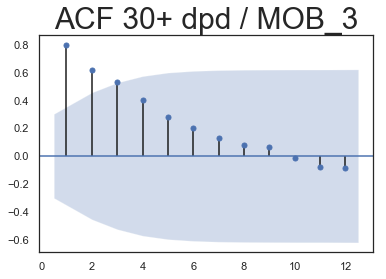

None


In [47]:
print(ACF(df_30_dpd_train['dpd30_MOB_3']))

## PACF

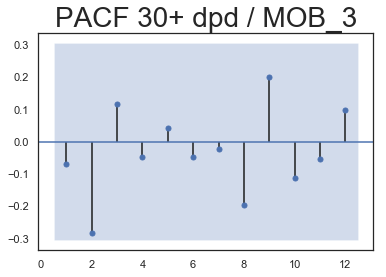

None


In [48]:
def PACF(a):
      sgt.plot_pacf(a, zero = False, alpha = 0.05,method = ('ols'), lags = 12)
      plt.title("PACF 30+ dpd / MOB_3", size = 28)
      plt.show()
        
print(PACF(Stationary_30dpd_MOB_3))

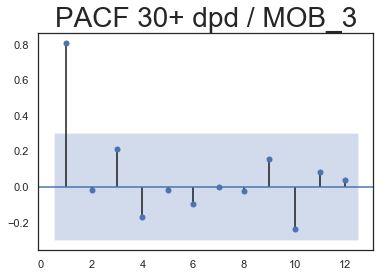

None


In [49]:
print(PACF(df_30_dpd_train['dpd30_MOB_3']))

## Auto ARIMA Prediction

In [50]:
df_poland_dpd = (df_30_dpd_train['dpd30_MOB_3'].iloc[1:])
model_Auto_Performing = auto_arima(df_poland_dpd)
model_Auto_Performing.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   41
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -250.568
Date:                Tue, 26 Jan 2021   AIC                            507.136
Time:                        23:20:27   BIC                            512.276
Sample:                             0   HQIC                           509.008
                                 - 41                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     76.9858     52.770      1.459      0.145     -26.442     180.413
ar.L1          0.8355      0.095      8.812      0.000       0.650       1.021
sigma2      1.156e+04   2286.214      5.059      0.000    7084.057     1.6e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.93   Prob(JB):                         0.48
Heteroskedasticity (H):               3.00   Skew:                             0.38
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
df_poland_dpd = (df_30_dpd_train['dpd30_MOB_3'].iloc[1:])
model_Auto_Performing = auto_arima(df_poland_dpd,information_criterion='hqic')
model_Auto_Performing.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   41
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -250.568
Date:                Tue, 26 Jan 2021   AIC                            507.136
Time:                        23:20:27   BIC                            512.276
Sample:                             0   HQIC                           509.008
                                 - 41                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     76.9858     52.770      1.459      0.145     -26.442     180.413
ar.L1          0.8355      0.095      8.812      0.000       0.650       1.021
sigma2      1.156e+04   2286.214      5.059      0.000    7084.057     1.6e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.93   Prob(JB):                         0.48
Heteroskedasticity (H):               3.00   Skew:                             0.38
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
df_poland_dpd = (df_30_dpd_train['dpd30_MOB_3'].iloc[1:])
model_Auto_Performing = auto_arima(df_poland_dpd,information_criterion='bic')
model_Auto_Performing.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   41
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -250.568
Date:                Tue, 26 Jan 2021   AIC                            507.136
Time:                        23:20:28   BIC                            512.276
Sample:                             0   HQIC                           509.008
                                 - 41                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     76.9858     52.770      1.459      0.145     -26.442     180.413
ar.L1          0.8355      0.095      8.812      0.000       0.650       1.021
sigma2      1.156e+04   2286.214      5.059      0.000    7084.057     1.6e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.93   Prob(JB):                         0.48
Heteroskedasticity (H):               3.00   Skew:                             0.38
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA Prediction

In [53]:
# walk-forward validation
history_30dpd_MOB_3 = [x for x in df_30_dpd_train['dpd30_MOB_3']]
predictions_30dpd = list()
for i in range(len(Test_set['dpd30_MOB_3'])):
    # predict
    model_dpd = ARIMA(history_30dpd_MOB_3, order=(1,0,0))
    model_dpd_fit = model_dpd.fit(disp=0)
    yhat = model_dpd_fit.forecast()[0]
    predictions_30dpd.append(yhat)
    # observation
    obs = Test_set['dpd30_MOB_3'][i]
    history_30dpd_MOB_3.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(Test_set['dpd30_MOB_3'], predictions_30dpd))
print('RMSE: %.3f' % rmse)

>Predicted=386.041, Expected=255.000
>Predicted=281.498, Expected=224.000
>Predicted=251.948, Expected=108.000
>Predicted=142.798, Expected=79.000
>Predicted=112.307, Expected=111.000
>Predicted=140.587, Expected=121.000
>Predicted=148.271, Expected=150.000
>Predicted=174.199, Expected=70.000
RMSE: 84.050


In [54]:
# walk-forward validation
history_30dpd_MOB_3 = [x for x in df_30_dpd_train['dpd30_MOB_3']]
predictions_30dpd = list()
for i in range(len(Test_set['dpd30_MOB_3'])):
    # predict
    model_dpd = ARIMA(history_30dpd_MOB_3, order=(1,1,1))
    model_dpd_fit = model_dpd.fit(disp=0)
    yhat = model_dpd_fit.forecast()[0]
    predictions_30dpd.append(yhat)
    # observation
    obs = Test_set['dpd30_MOB_3'][i]
    history_30dpd_MOB_3.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(Test_set['dpd30_MOB_3'], predictions_30dpd))
print('RMSE: %.3f' % rmse)

>Predicted=374.435, Expected=255.000
>Predicted=272.417, Expected=224.000
>Predicted=238.327, Expected=108.000
>Predicted=128.285, Expected=79.000
>Predicted=90.803, Expected=111.000
>Predicted=113.154, Expected=121.000
>Predicted=120.274, Expected=150.000
>Predicted=145.883, Expected=70.000
RMSE: 73.429


In [55]:
# walk-forward validation
history_30dpd_MOB_3 = [x for x in df_30_dpd_train['dpd30_MOB_3']]
predictions_30dpd = list()
for i in range(len(Test_set['dpd30_MOB_3'])):
    # predict
    model_dpd = ARIMA(history_30dpd_MOB_3, order=(1,1,0))
    model_dpd_fit = model_dpd.fit(disp=0)
    yhat = model_dpd_fit.forecast()[0]
    predictions_30dpd.append(yhat)
    # observation
    obs = Test_set['dpd30_MOB_3'][i]
    history_30dpd_MOB_3.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(Test_set['dpd30_MOB_3'], predictions_30dpd))
print('RMSE: %.3f' % rmse)

>Predicted=373.719, Expected=255.000
>Predicted=266.817, Expected=224.000
>Predicted=227.428, Expected=108.000
>Predicted=113.964, Expected=79.000
>Predicted=78.372, Expected=111.000
>Predicted=107.536, Expected=121.000
>Predicted=119.128, Expected=150.000
>Predicted=147.689, Expected=70.000
RMSE: 70.398


## Residual Validation

RMSE: 70.398
                0
count    8.000000
mean   -39.581608
std     62.236695
min   -119.427661
25%    -87.946288
50%    -38.890522
75%     17.815790
max     32.627736


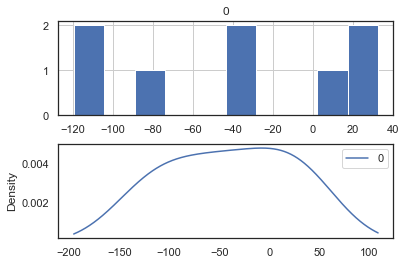

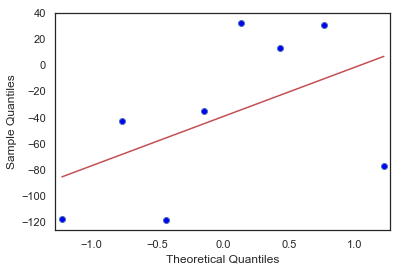

In [56]:
# walk-forward validation
history_30dpd_MOB_3 = [x for x in df_30_dpd_train['dpd30_MOB_3']]
predictions_30dpd = list()
for i in range(len(Test_set['dpd30_MOB_3'])):
    # predict
    model_dpd = ARIMA(history_30dpd_MOB_3, order=(1,1,0))
    model_dpd_fit = model_dpd.fit(disp=0)
    yhat = model_dpd_fit.forecast()[0]
    predictions_30dpd.append(yhat)
    # observation
    obs = Test_set['dpd30_MOB_3'][i]
    history_30dpd_MOB_3.append(obs)
    #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(Test_set['dpd30_MOB_3'], predictions_30dpd))
print('RMSE: %.3f' % rmse)

# errors
residuals = [Test_set['dpd30_MOB_3'][i]-predictions_30dpd[i] for i in range(len(Test_set['dpd30_MOB_3']))]
residuals = DataFrame(residuals)
print(residuals.describe())

# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
qqplot(residuals, line='r')
plt.show()

RMSE: 58.217
                  0
count  8.000000e+00
mean   3.513717e-07
std    6.223670e+01
min   -7.984605e+01
25%   -4.836468e+01
50%    6.910859e-01
75%    5.739740e+01
max    7.220934e+01


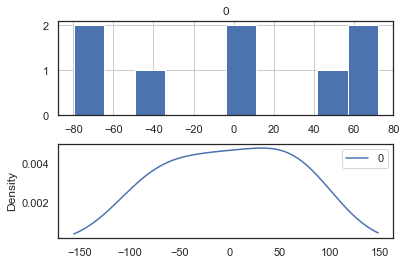

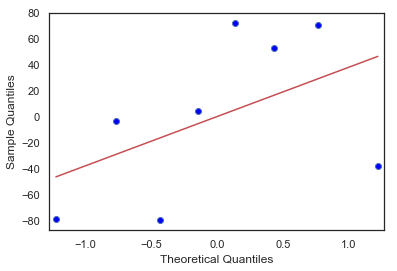

In [57]:
# walk-forward validation
history_30dpd_MOB_3 = [x for x in df_30_dpd_train['dpd30_MOB_3']]
predictions_30dpd = list()
bias = -39.581608
for i in range(len(Test_set['dpd30_MOB_3'])):
    # predict
    model_dpd = ARIMA(history_30dpd_MOB_3, order=(1,1,0))
    model_dpd_fit = model_dpd.fit(disp=0)
    yhat = bias +  model_dpd_fit.forecast()[0]
    predictions_30dpd.append(yhat)
    # observation
    obs = Test_set['dpd30_MOB_3'][i]
    history_30dpd_MOB_3.append(obs)
    #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(Test_set['dpd30_MOB_3'], predictions_30dpd))
print('RMSE: %.3f' % rmse)

# errors
residuals = [Test_set['dpd30_MOB_3'][i]-predictions_30dpd[i] for i in range(len(Test_set['dpd30_MOB_3']))]
residuals = DataFrame(residuals)
print(residuals.describe())

# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
qqplot(residuals, line='r')
plt.show()

In [58]:
# walk-forward validation
history_30dpd_MOB_3 = [x for x in df_30_dpd_train['dpd30_MOB_3']]
predictions_30dpd = list()
bias = -39.581608
for i in range(len(Test_set['dpd30_MOB_3'])):
    # predict
    model_dpd = ARIMA(history_30dpd_MOB_3, order=(1,1,0))
    model_dpd_fit = model_dpd.fit(disp=0)
    yhat = bias + model_dpd_fit.forecast()[0]
    predictions_30dpd.append(yhat)
    # observation
    obs = Test_set['dpd30_MOB_3'][i]
    history_30dpd_MOB_3.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(Test_set['dpd30_MOB_3'], predictions_30dpd))
mae = mean_absolute_error(Test_set['dpd30_MOB_3'], predictions_30dpd)


print('RMSE: %.3f' % rmse)
print('MAE: %f' % mae)

>Predicted=334.138, Expected=255.000
>Predicted=227.236, Expected=224.000
>Predicted=187.846, Expected=108.000
>Predicted=74.382, Expected=79.000
>Predicted=38.791, Expected=111.000
>Predicted=67.955, Expected=121.000
>Predicted=79.546, Expected=150.000
>Predicted=108.107, Expected=70.000
RMSE: 58.217
MAE: 50.081635


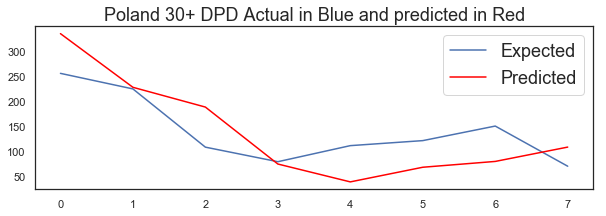

In [59]:
# Plot
plt.figure(figsize=(10,3))
plt.plot(Test_set['dpd30_MOB_3'].reset_index(drop=True),label = "Expected")
plt.plot(predictions_30dpd, color='red', label = "Predicted")
#Test_set['dpd30_MOB_3'].plot(figsize = (25,5), label = "wn_dpd30", fontsize = 18)
plt.title('Poland 30+ DPD Actual in Blue and predicted in Red',fontsize = 18)
plt.legend(fontsize = 18)
plt.show()

# XGBOOST for 30+ DPD

In [60]:
#df_30_90_dpd = df_30_90_dpd.reset_index()
df_30_90_dpd = df_30_90_dpd.drop(['90_dpd_MOB_6'], axis=1)

In [61]:
# remove the zeros to enhance the learning
df_30_dpd_Ml = df_30_90_dpd[7:-5]
df_30_dpd_Ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 2016-03 to 2020-04
Data columns (total 1 columns):
dpd30_MOB_3    50 non-null int64
dtypes: int64(1)
memory usage: 800.0+ bytes


In [62]:
# Create a superviced Model
df_30_dpd_Ml["target"] = df_30_dpd_Ml['dpd30_MOB_3'].shift(-1)
df_30_dpd_Ml.dropna(inplace=True)

In [63]:
def train_test_split(data):
    data = data.values
    n = int(len(data)- (len(data)*0.15))
    #print(n)
    return data[:n], data[n:]

In [64]:
train, test = train_test_split(df_30_dpd_Ml)

In [65]:
print(len(df_30_dpd_Ml))
print(len(train))
print(len(test))

49
41
8


In [66]:
print(test)

[[373. 255.]
 [255. 224.]
 [224. 108.]
 [108.  79.]
 [ 79. 111.]
 [111. 121.]
 [121. 150.]
 [150.  70.]]


In [67]:
def xgb_predict(train, val):
    train = np.array(train)
    X, y = train[:, :-1], train[:, -1]
    model = XGBRegressor(max_depth=1,objective="count:poisson", n_estimators=1000, reg_lambda=1)
    model.fit(X, y)

    val = np.array(val).reshape(1, -1)
    pred = model.predict(val)
    return pred[0]

In [68]:
xgb_predict(train, test[0, 0])

415.59204

In [69]:
def validate(data, perc):
    predictions = []

    train, test = train_test_split(data)

    history = [x for x in train]

    for i in range(len(test)):
        test_X, test_y = test[i, :-1], test[i, -1]

        pred = xgb_predict(history, test_X)
        predictions.append(pred)

        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (test_y, pred))

    error = mean_squared_error(test[:, -1], predictions, squared=False)
    error_1= mean_absolute_error(test[:, -1], predictions)
        
    return error, test[:, -1], predictions,error_1

In [70]:
rmse, y, pred, mae = validate(df_30_dpd_Ml, 11)
print('rmse: %.3f' % rmse)
print('mae: %.3f' % mae)

>expected=255.0, predicted=415.6
>expected=224.0, predicted=310.5
>expected=108.0, predicted=258.4
>expected=79.0, predicted=199.6
>expected=111.0, predicted=85.5
>expected=121.0, predicted=97.0
>expected=150.0, predicted=123.6
>expected=70.0, predicted=192.8
rmse: 104.553
mae: 89.606


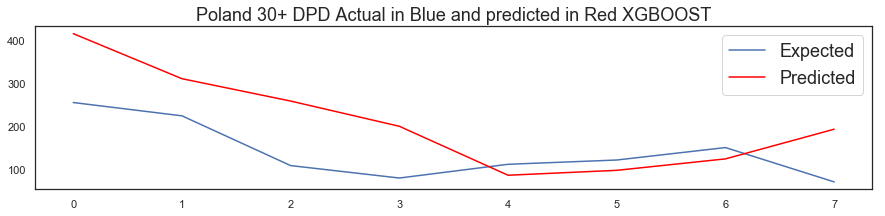

In [71]:
# plot expected vs preducted
plt.figure(figsize=(15,3))
plt.plot(y, label='Expected')
plt.plot(pred, label='Predicted', color='red')
plt.title('Poland 30+ DPD Actual in Blue and predicted in Red XGBOOST',fontsize = 18)
plt.legend(fontsize = 18)
plt.show()